## Import & Process Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Data Cleaning

In [2]:
img_url = sorted(glob.glob('data/ISIC-images'+"/*.jpg"))
csv_names = [i for i in glob.glob('data'+'/*.csv')]
df = pd.read_csv('data/metadata.csv')

short=[]
for i in img_url:
    short.append(i[17:-4])
img_name = pd.Series(short,name='name')

df = pd.merge(df, img_name, on='name', how='inner')
df['image'] = img_url

df = df[['meta.clinical.diagnosis', 'image']]
df_na = df.copy()
df = df[df['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
df.columns = ['diagnosis', 'image']
df['diagnosis'] = (df['diagnosis'] == 'melanoma').astype(int)

#### Deleted null values from dataset

In [3]:
df_na[df_na['meta.clinical.diagnosis'].isna()]

,meta.clinical.diagnosis,image
257,NaN,data/ISIC-images/ISIC_0000257.jpg
454,NaN,data/ISIC-images/ISIC_0000454.jpg
9892,NaN,data/ISIC-images/ISIC_0009892.jpg
9893,NaN,data/ISIC-images/ISIC_0009893.jpg
9924,NaN,data/ISIC-images/ISIC_0009924.jpg
...,...,...
13786,NaN,data/ISIC-images/ISIC_0024202.jpg
13787,NaN,data/ISIC-images/ISIC_0024203.jpg
13788,NaN,data/ISIC-images/ISIC_0024204.jpg
13789,NaN,data/ISIC-images/ISIC_0024205.jpg


##### df = All dataset

## EDA

In [4]:
diagnosis = df['diagnosis']

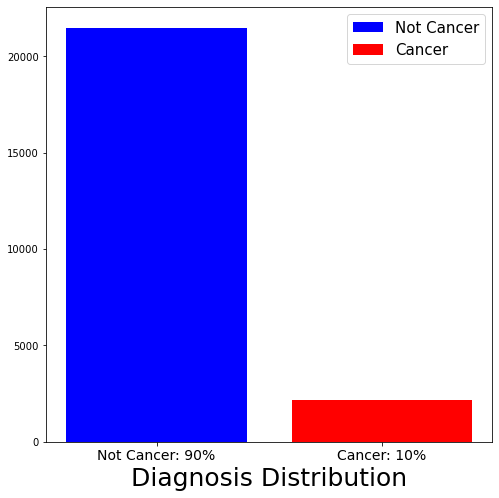

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 14
x0 = (diagnosis==0).sum()
x1 = (diagnosis==1).sum()

ax.set_xlabel('Diagnosis Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90%', 'Cancer: 10%'], size=xtick)
plt.legend(prop={'size': 15})
plt.show()

## Pipeline

In [6]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [24]:
def import_dataset(img_path, data_path):
    img_url = sorted(glob.glob(img_path+"/*.jpg"))
    csv_names = [i for i in glob.glob(data_path+'/*.csv')]
    df = pd.concat([pd.read_csv(f) for f in csv_names]).sort_values('name').reset_index(drop=True)
    df['image'] = img_url
    return df

def clean_dataset(df):
    dataset = df.copy()
    dataset = dataset[['meta.clinical.diagnosis', 'image']]
    dataset = dataset[dataset['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
    dataset.columns = ['diagnosis', 'image']
    dataset['diagnosis'] = (dataset['diagnosis'] == 'melanoma').astype(int)
    return dataset

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set

In [18]:
df

,diagnosis,image
0,0,data/ISIC-images/ISIC_0000000.jpg
1,0,data/ISIC-images/ISIC_0000001.jpg
2,1,data/ISIC-images/ISIC_0000002.jpg
3,0,data/ISIC-images/ISIC_0000003.jpg
4,1,data/ISIC-images/ISIC_0000004.jpg
...,...,...
23648,1,data/ISIC-images/ISIC_0034316.jpg
23649,1,data/ISIC-images/ISIC_0034317.jpg
23650,0,data/ISIC-images/ISIC_0034318.jpg
23651,0,data/ISIC-images/ISIC_0034319.jpg


In [16]:
(df['diagnosis']==0).sum()

21485

In [17]:
(df['diagnosis']==1).sum()

2168

In [14]:
df[df['diagnosis']==0]['diagnosis'].count()

21485

In [22]:
df

,diagnosis,image
0,0,data/ISIC-images/ISIC_0000000.jpg
1,0,data/ISIC-images/ISIC_0000001.jpg
2,1,data/ISIC-images/ISIC_0000002.jpg
3,0,data/ISIC-images/ISIC_0000003.jpg
4,1,data/ISIC-images/ISIC_0000004.jpg
...,...,...
23648,1,data/ISIC-images/ISIC_0034316.jpg
23649,1,data/ISIC-images/ISIC_0034317.jpg
23650,0,data/ISIC-images/ISIC_0034318.jpg
23651,0,data/ISIC-images/ISIC_0034319.jpg


In [25]:
X, y = create_X_y(df)

In [ ]:
# Train/test split for Train Set
train, test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [92]:
# Importing and creating test set. Returns X & y.
test_df = import_dataset('img_sample/img_test','data_sample/data_test')
test_df_cleaned = clean_dataset(test_df)
X_test, y_test = create_X_y(test_df_cleaned)

#### Creating Train Set

In [93]:
# Train Set
path = "img_sample/img_train"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

negative_csv =[i for i in glob.glob('data_sample/data_train/0/*.csv')]
positive_csv =[i for i in glob.glob('data_sample/data_train/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [96]:
# Train Set
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [97]:
# Create X and y for Train set
y = lbl_img_cl['diagnosis']
X = []
for i in fileimages:
    image = load_and_preprocess_image(i)
    X.append(np.asarray(image))

In [12]:
# Train/test split for Train Set
X_train, X_val, y_train, y_val = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)

#### Train Model

In [55]:
# def train_model(X_train, y_train, model_type=keras.Sequential(), input_shape=(100,100,3), activation='softmax', epochs=10):
#     model = model_type
#     model.add(keras.layers.Flatten(input_shape=input_shape))
#     model.add(keras.layers.Dense(2, activation=activation))

#     model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#     model.fit(X_train, y_train, epochs=epochs)
#     return model
# model = train_model(X_train, y_train)

In [65]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [66]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 3s 110ms/step - loss: 0.6919 - accuracy: 0.5288
Epoch 2/100
25/25 [==============================] - 3s 105ms/step - loss: 0.6735 - accuracy: 0.5915
Epoch 3/100
25/25 [==============================] - 3s 105ms/step - loss: 0.6543 - accuracy: 0.6253
Epoch 4/100
25/25 [==============================] - 3s 107ms/step - loss: 0.6370 - accuracy: 0.6754
Epoch 5/100
25/25 [==============================] - 3s 105ms/step - loss: 0.5966 - accuracy: 0.6942
Epoch 6/100
25/25 [==============================] - 3s 106ms/step - loss: 0.5805 - accuracy: 0.7055
Epoch 7/100
25/25 [==============================] - 3s 105ms/step - loss: 0.5658 - accuracy: 0.7231
Epoch 8/100
25/25 [==============================] - 3s 105ms/step - loss: 0.5478 - accuracy: 0.7281
Epoch 9/100
25/25 [==============================] - 3s 107ms/step - loss: 0.5391 - accuracy: 0.7531
Epoch 10/100
25/25 [==============================] - 3s 105ms/step - loss: 0.5258 - accura

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 64)       

## Evalaution

In [58]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.2f}'.format(tp/(tp+fn)))
    print('Precision: {:.2f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.2f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.2f}'.format(roc_auc_score(y_test, y_pred)))

### Validation Set and Test Set

In [69]:
# Validation Set
val_loss1, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Validation set accuracy {:5.2f}%'.format(100*val_acc))
# Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))

Validation set accuracy 83.50%
Test set accuracy 57.67%


In [70]:
# Validation Set
y_val_pred = np.argmax(model.predict(X_val), axis=-1)
matrix_score(y_val, y_val_pred)

[[85 15]
 [18 82]]
Recall:    0.85
Precision: 0.83
Accuracy:  0.83
ROC AUC:   0.84


In [71]:
# Test Set
y_test_pred = np.argmax(model.predict(X_test), axis=-1)
matrix_score(y_test, y_test_pred)

[[ 22  55]
 [ 72 151]]
Recall:    0.29
Precision: 0.23
Accuracy:  0.58
ROC AUC:   0.48


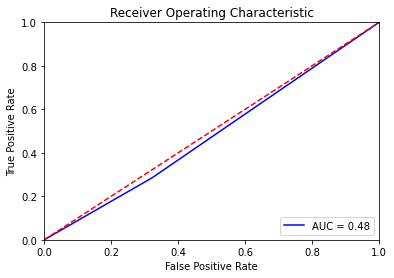

In [72]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()